## Imports

In [53]:
from keras.datasets import cifar10
from keras.utils import to_categorical
from keras.models import Sequential, Model, load_model
from keras.layers import Conv2D, Flatten, Dense, Dropout, AveragePooling2D, BatchNormalization
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

import numpy as np


## Load Data

In [32]:
# Load Data
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

# Standardize values 0 - 1
X_train, X_test = (X_train / 255), (X_test / 255)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# One Hot Encode Labels
y_train = to_categorical(y_train, 10)
y_val = to_categorical(y_val, 10)
y_test = to_categorical(y_test, 10)

In [33]:
# print(f'X_train.shape: {X_train[0]}')
# print(f'y_train[0] {y_train[0]}')

## Plot Images

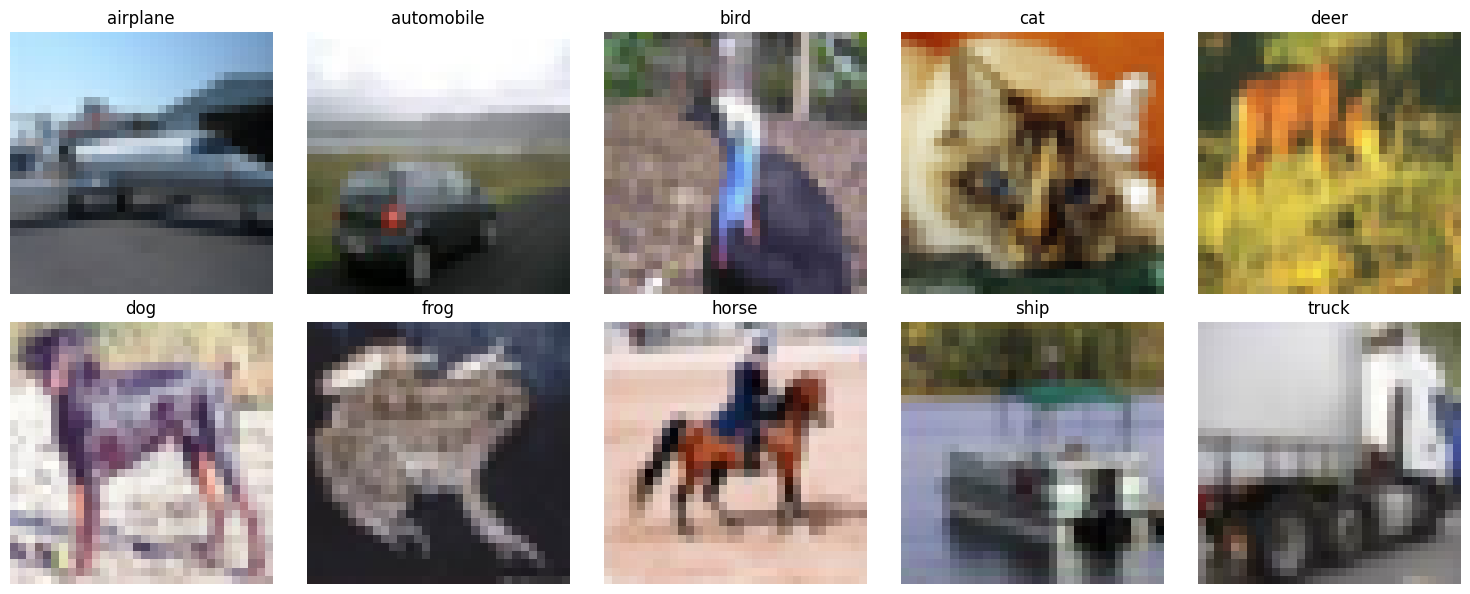

In [66]:
# Name of Labels
class_labels = [
    'airplane', 'automobile', 'bird', 'cat', 'deer',
    'dog', 'frog', 'horse', 'ship', 'truck'
]

# Plot 1 of each Label
plt.figure(figsize=(15, 6))

# loop through # of classes (10 classes)
for i in range(10):
  # get the index of the first occurrence of class i
  for idx, label in enumerate(y_train):
    # check if i == 1
    if label[i] == 1:
      # plot it
      ax = plt.subplot(2, 5, i+1) # create a subplot for each image
      ax.imshow(X_train[idx])
      ax.set_title(class_labels[i])
      ax.axis('off')
      break

plt.tight_layout()
plt.show()



## Data Augmentation

In [35]:
train_datagen = ImageDataGenerator(
    rotation_range=15,
    horizontal_flip=True,
    #vertical_flip=True,
    height_shift_range=0.1,
    width_shift_range=0.1,
)
train_datagen.fit(X_train)

val_datagen = ImageDataGenerator()
val_datagen.fit(X_val)

train_generator = train_datagen.flow(X_train, y_train, batch_size=32)
val_generator = val_datagen.flow(X_val, y_val, batch_size=32)


## Plot Data Augmentation

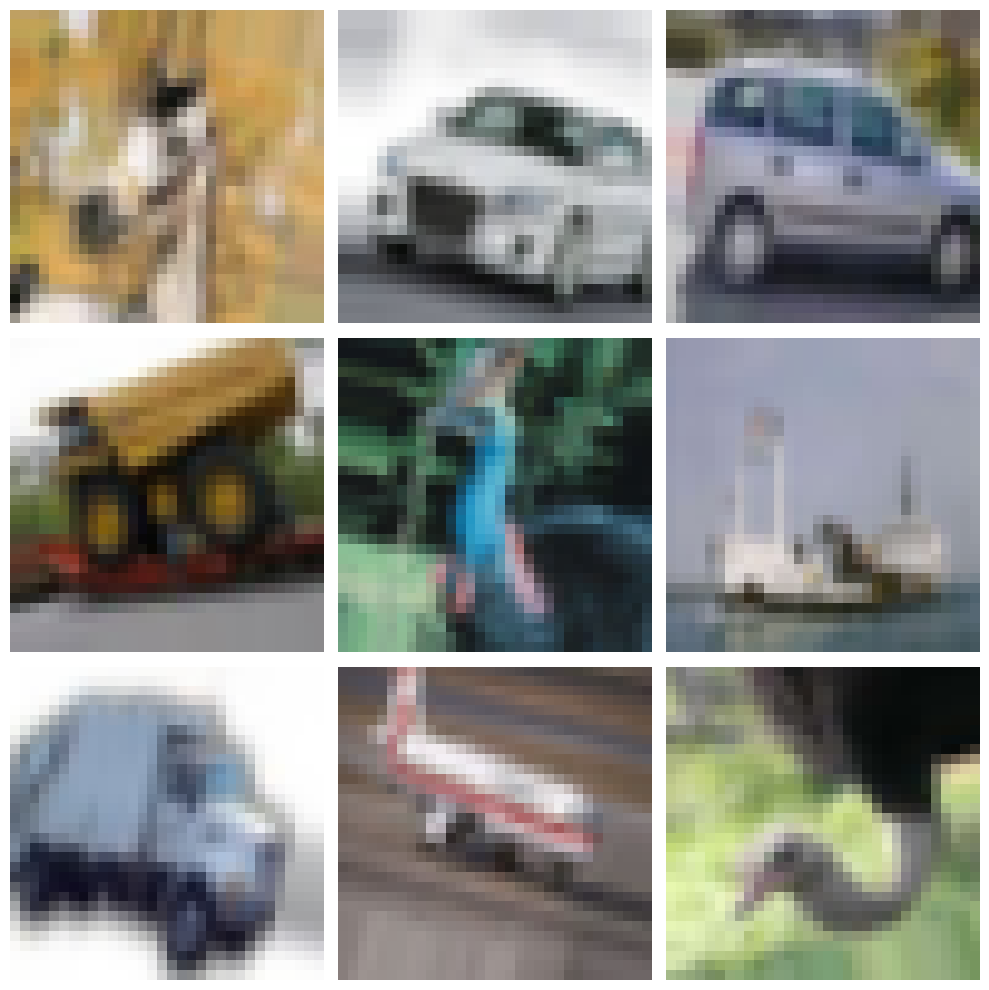

In [72]:
augmented_images, labels = next(train_generator)

fig, axes = plt.subplots(3, 3, figsize=(10, 10))
axes = axes.flatten()

for img, ax in zip(augmented_images, axes):
  ax.imshow(img)
  ax.axis('off')

plt.tight_layout()
plt.show()



## Model

In [37]:
model = Sequential(
    [

        Conv2D(filters=32, kernel_size=(3,3), activation='relu', input_shape=(32,32,3), padding='same'),
        BatchNormalization(),
        Conv2D(filters=32, kernel_size=(3,3), activation='relu', padding='same'),
        BatchNormalization(),
        AveragePooling2D(2, 2),


        Conv2D(filters=64, kernel_size=(3,3), activation='relu', padding='same'),
        BatchNormalization(),
        Conv2D(filters=64, kernel_size=(3,3), activation='relu', padding='same'),
        BatchNormalization(),
        AveragePooling2D(2, 2),

        Conv2D(filters=128, kernel_size=(3,3), activation='relu', padding='same'),
        BatchNormalization(),
        Conv2D(filters=128, kernel_size=(3,3), activation='relu', padding='same'),
        BatchNormalization(),
        AveragePooling2D(2, 2),

        Conv2D(filters=256, kernel_size=(3,3), activation='relu', padding='same'),
        BatchNormalization(),
        Conv2D(filters=256, kernel_size=(3,3), activation='relu', padding='same'),
        BatchNormalization(),
        AveragePooling2D(2, 2),

        Flatten(),

        # Fourth Layer
        Dense(512, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        # Fifth Layer
        Dense(256, activation='relu'),
        BatchNormalization(),
        Dropout(0.4),
        # Sixth Layer
        Dense(128, activation='relu'),
        BatchNormalization(),
        Dropout(0.4),
        Dense(64, activation='relu'),
        Dropout(0.3),
        Dense(32, activation='relu'),


        # Seventh and Final Layer
        Dense(10, activation='softmax')
    ]
)

## Compile

In [38]:
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

## Summary

In [39]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_16 (Conv2D)          (None, 32, 32, 32)        896       
                                                                 
 batch_normalization_22 (Ba  (None, 32, 32, 32)        128       
 tchNormalization)                                               
                                                                 
 conv2d_17 (Conv2D)          (None, 32, 32, 32)        9248      
                                                                 
 batch_normalization_23 (Ba  (None, 32, 32, 32)        128       
 tchNormalization)                                               
                                                                 
 average_pooling2d_8 (Avera  (None, 16, 16, 32)        0         
 gePooling2D)                                                    
                                                      

## Earlystopping / Checkpoint

In [40]:
early_stopping = EarlyStopping(
    monitor='val_accuracy',
    min_delta=0.001,
    patience=7,
    verbose=1
)

checkpoint = ModelCheckpoint(filepath='best_model.keras',
                             monitor='val_accuracy',
                             save_best_only=True,
                             mode='max',
                             verbose=1
                             )

callbacks = [early_stopping, checkpoint]

## Model No Data Augmentation

In [41]:
# history = model.fit(
#     X_train,
#     y_train,
#     epochs=100,
#     batch_size=32,
#     validation_split=0.2,
#     callbacks=callbacks
# )

### Plot

In [42]:
# plt.plot(history.history['loss'], label='Train Loss')
# plt.plot(history.history['val_loss'], label='Val Loss')
# plt.legend()
# plt.show()

In [43]:
# plt.plot(history.history['accuracy'], label='Train Acc')
# plt.plot(history.history['val_accuracy'], label='Val Acc')
# plt.legend()
# plt.show()

### Test Eval

In [44]:
# test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)

## Data Augmented Model

In [45]:
da_hist = model.fit(
    train_generator,
    epochs=100,
    validation_data=(X_val, y_val),  # Directly use the validation set
    batch_size=32,
    validation_batch_size=32,
    callbacks=[callbacks]
)

Epoch 1/100
1250/1250 [==============================] - ETA: 0s - loss: 1.9405 - accuracy: 0.2702
Epoch 1: val_accuracy improved from -inf to 0.26720, saving model to best_model.keras
1250/1250 [==============================] - 46s 31ms/step - loss: 1.9405 - accuracy: 0.2702 - val_loss: 2.0547 - val_accuracy: 0.2672
Epoch 2/100
1249/1250 [============================>.] - ETA: 0s - loss: 1.5652 - accuracy: 0.4232
Epoch 2: val_accuracy improved from 0.26720 to 0.40030, saving model to best_model.keras
1250/1250 [==============================] - 38s 30ms/step - loss: 1.5652 - accuracy: 0.4233 - val_loss: 1.8285 - val_accuracy: 0.4003
Epoch 3/100
1249/1250 [============================>.] - ETA: 0s - loss: 1.3523 - accuracy: 0.5239
Epoch 3: val_accuracy improved from 0.40030 to 0.58210, saving model to best_model.keras
1250/1250 [==============================] - 38s 30ms/step - loss: 1.3521 - accuracy: 0.5240 - val_loss: 1.2167 - val_accuracy: 0.5821
Epoch 4/100
1248/1250 [===========

## Plot da_hist

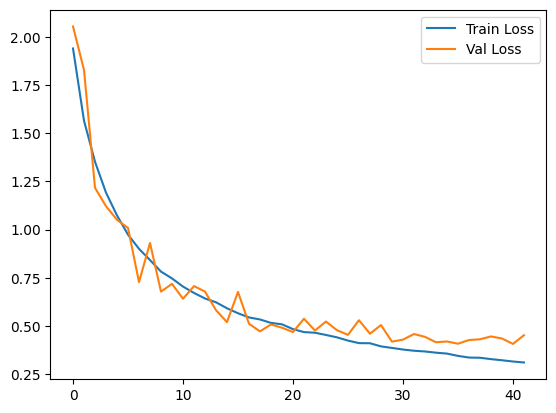

In [46]:
plt.plot(da_hist.history['loss'], label='Train Loss')
plt.plot(da_hist.history['val_loss'], label='Val Loss')
plt.legend()
plt.show()

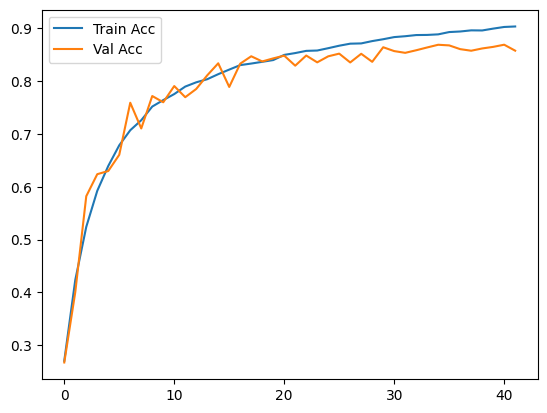

In [47]:
plt.plot(da_hist.history['accuracy'], label='Train Acc')
plt.plot(da_hist.history['val_accuracy'], label='Val Acc')
plt.legend()
plt.show()

In [54]:
best_model = load_model('best_model.keras')
da_test_loss, da_test_acc = best_model.evaluate(X_test, y_test, verbose=2)

313/313 - 2s - loss: 0.4234 - accuracy: 0.8660 - 2s/epoch - 5ms/step


## Feature Maps

In [49]:
def plot_feature_maps(feature_maps, layer_index=0):
    # Extract the feature maps for a specific layer
    layer_feature_maps = feature_maps[layer_index]

    # Determine the number of feature maps
    num_feature_maps = layer_feature_maps.shape[-1]

    # Set up the subplot grid — we choose a square layout to maximize space
    grid_size = int(np.ceil(np.sqrt(num_feature_maps)))
    fig, axes = plt.subplots(grid_size, grid_size, figsize=(15, 15))

    # Plot each feature map
    for i in range(grid_size ** 2):
        ax = axes[i // grid_size, i % grid_size]
        if i < num_feature_maps:
            ax.imshow(layer_feature_maps[0, :, :, i], cmap='viridis')
        ax.axis('off')

    plt.tight_layout()
    plt.show()

# the output from the conv layers
layer_outputs = [layer.output for layer in model.layers if 'conv' in layer.name]
#create dummy model for feature maps
feature_map_model = Model(inputs=best_model.input, outputs=layer_outputs)

feature_maps = feature_map_model.predict(X_train[0:1])

1/1 [==============================] - 0s 498ms/step


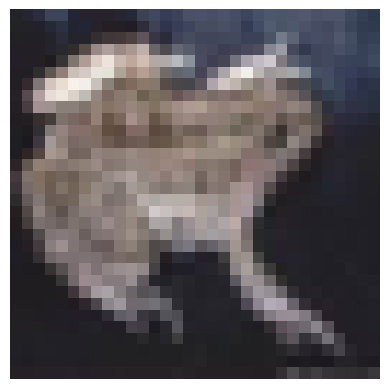

In [50]:
plt.imshow(X_train[0])
plt.axis('off')
plt.show()

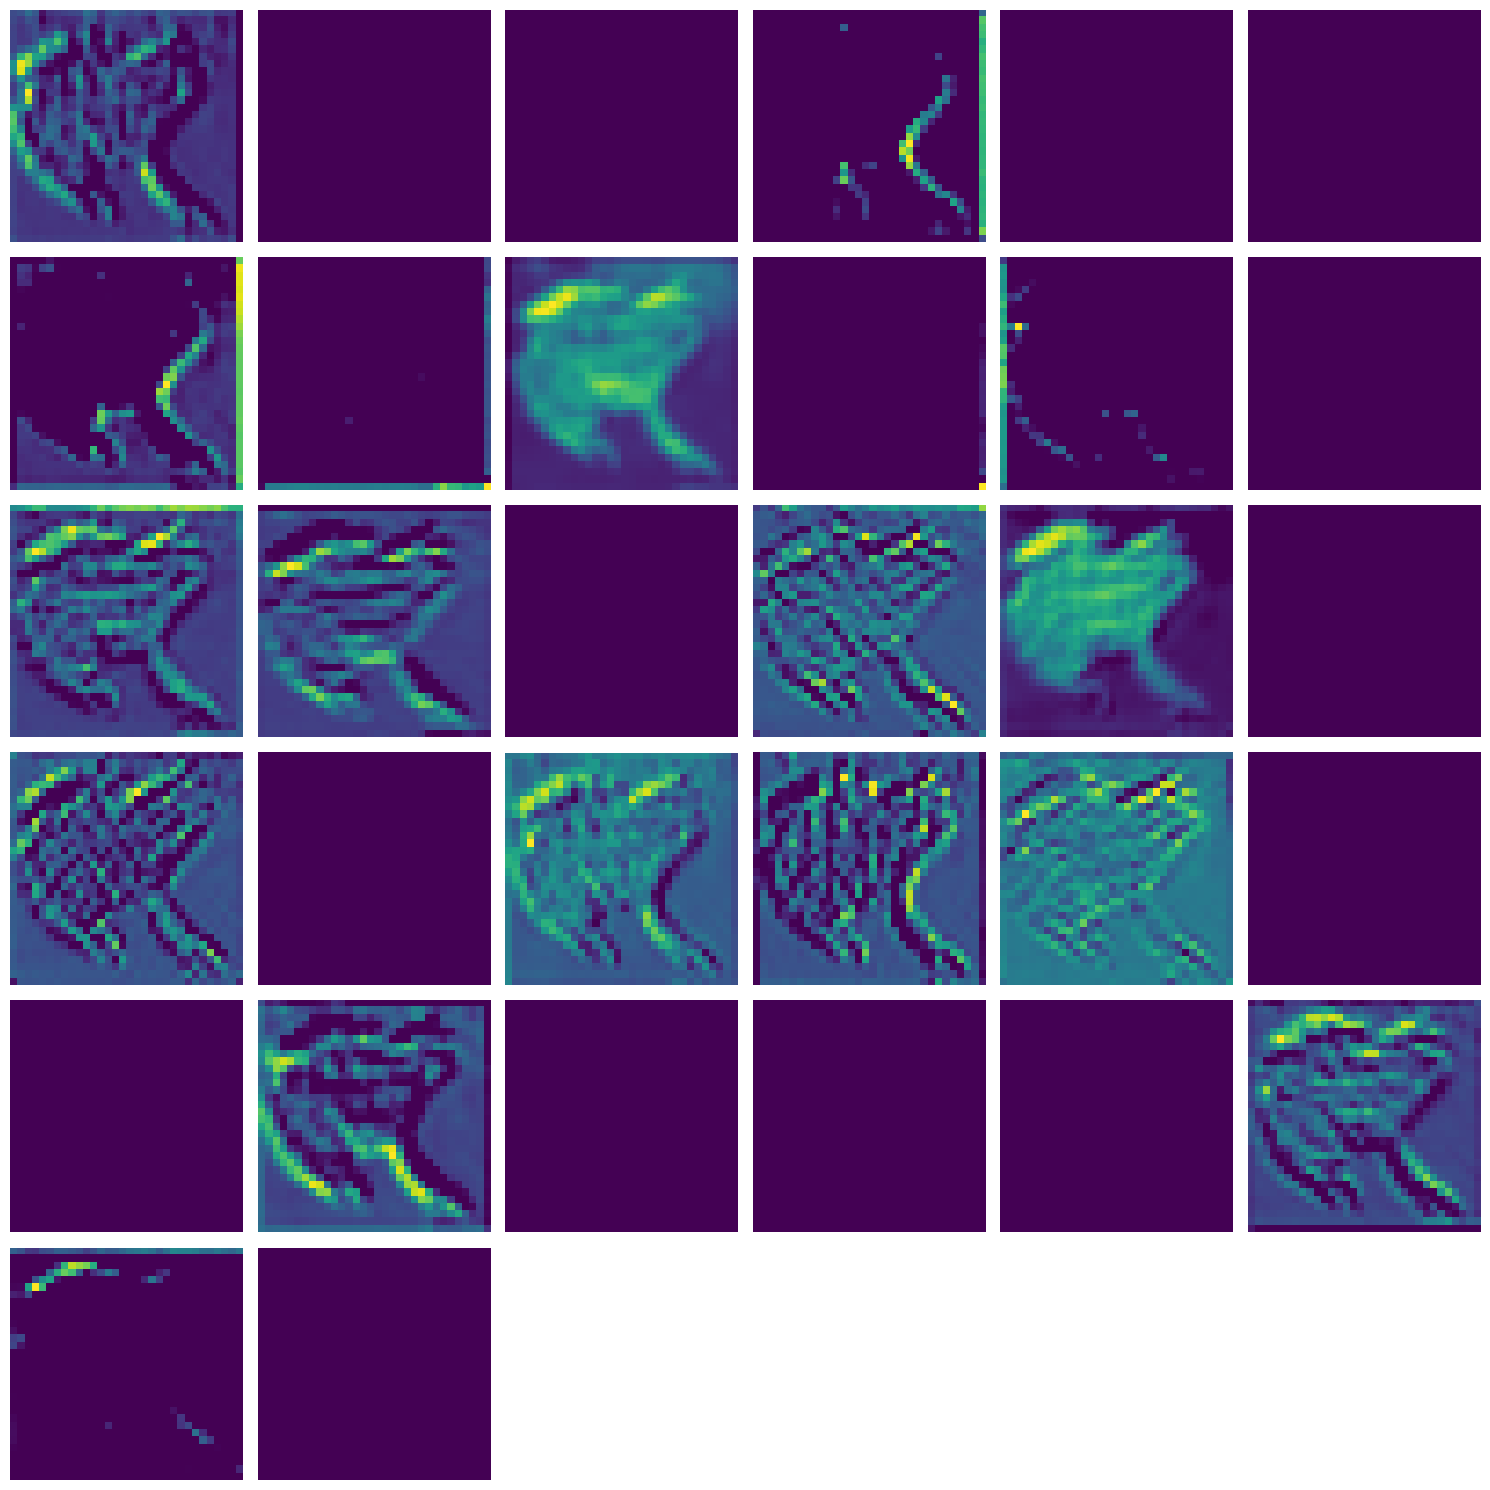

In [51]:
plot_feature_maps(feature_maps, layer_index=0)